In [116]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_curve, auc
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import shap


In [31]:
ignore = ['TroponinI', 'Fibrinogen', 'EtCO2', 'Bilirubin_direct']
ignore_mice_A = ['Unit2']
df_sample = pd.read_csv('data_samples/patient_0_train.psv', sep='|')
df_sample.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [32]:
def SIRS(row):
    sirs = ['HR', 'Temp', 'PaCO2', 'Resp', 'WBC']
    counter_sirs = 0
    if row['HR'] > 90:
        counter_sirs +=1
    if row['Temp'] < 36 or row['Temp'] > 38:
        counter_sirs += 1
    if row['PaCO2'] < 32 or row['Resp'] > 20:
        counter_sirs += 1
    if row['WBC'] > 12000 or row['WBC'] < 4000:
        counter_sirs += 1
    return counter_sirs


def transform_data_with_SIRS(df):
    """
    Returns the whole df if the patient didn't have sepsis (and label 0), or the truncated df if the patient had sepsis
    (up until the first row with SepsisLabel=1, and label 1). In addition create new SIRS column - count the creiteria number
    """
    
    df['SIRS'] = df.apply(SIRS, axis=1)
    
    if df['SepsisLabel'].sum() == 0:
        return df.drop(columns='SepsisLabel').drop(columns=ignore), 0
    ind = df.SepsisLabel.where(df.SepsisLabel == 1).first_valid_index()
    return df.drop(columns='SepsisLabel').drop(columns=ignore).loc[0:ind], 1

def transform_data_with_SIRS_mice(df):
    """
    Returns the whole df if the patient didn't have sepsis (and label 0), or the truncated df if the patient had sepsis
    (up until the first row with SepsisLabel=1, and label 1). In addition create new SIRS column - count the creiteria number
    """
    
    df['SIRS'] = df.apply(SIRS, axis=1)
    
    if df['SepsisLabel'].sum() == 0:
        return df.drop(columns='SepsisLabel').drop(columns=ignore_mice_A), 0
    ind = df.SepsisLabel.where(df.SepsisLabel == 1).first_valid_index()
    return df.drop(columns='SepsisLabel').drop(columns=ignore_mice_A).loc[0:ind], 1

# Mean imputation

In [20]:
X_train = []
Y_train = []
for file in os.listdir('../data/train/'):
    df = pd.read_csv(f"../data/train/{file}", sep='|')
    transformed_data, label = transform_data_with_SIRS(df)
    transformed_data['ICULOS'] = transformed_data['ICULOS'].max()
    mean_data = pd.DataFrame(transformed_data.mean()).T
    X_train.append(mean_data)
    Y_train.append(label)
all_data_means = pd.concat(X_train).reset_index(drop=True)

In [21]:
# leave one column of unit and impute by most frequent value
all_data_means = all_data_means.drop(columns='Unit2')
most_freq_unit = all_data_means['Unit1'].value_counts().index[0]
all_data_means['Unit1'] = all_data_means['Unit1'].fillna(most_freq_unit)
# mean imputation to all other columns
mean_imp = all_data_means.mean()
all_data_means = all_data_means.fillna(all_data_means.mean())
all_data_means

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Hgb,PTT,WBC,Platelets,Age,Gender,Unit1,HospAdmTime,ICULOS,SIRS
0,61.215909,97.269231,36.857143,124.163265,58.135417,37.214286,22.771739,-0.483634,24.386175,0.375000,...,9.85000,36.950855,10.000000,78.000000,77.00,0.0,0.0,-679.93,52.0,0.576923
1,102.000000,98.000000,36.838671,113.500000,68.165000,64.096169,19.500000,-0.483634,24.386175,1.000000,...,10.71697,36.950855,11.013111,207.232551,80.47,0.0,0.0,-252.79,3.0,0.666667
2,90.023256,98.921053,37.028333,112.135135,83.630541,64.096169,14.918605,-0.483634,24.000000,0.637069,...,10.30000,36.950855,5.000000,266.500000,59.47,1.0,0.0,-0.03,51.0,0.437500
3,102.203704,97.285714,36.561765,123.634615,78.870370,66.538462,17.629630,-3.642857,22.000000,0.555556,...,10.87500,39.900000,16.050000,185.500000,79.16,0.0,0.0,0.80,28.0,1.259259
4,79.851852,96.296296,36.890909,105.814815,77.423077,60.888889,16.037037,-0.483634,24.386175,0.637069,...,12.15000,36.950855,13.350000,141.000000,59.00,1.0,0.0,-14.04,45.0,0.177778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,64.765625,99.016129,36.461429,102.075000,69.483871,50.325000,16.609375,-5.000000,18.500000,0.637069,...,11.75000,85.166667,9.350000,279.000000,71.89,1.0,0.0,-62.71,35.0,0.400000
19996,72.322581,96.725806,36.400000,115.600000,82.400000,62.933333,20.574074,-0.483634,24.386175,0.637069,...,10.00000,36.950855,8.300000,454.000000,73.00,0.0,0.0,-3.77,33.0,0.484848
19997,81.675676,97.869565,36.992857,112.162162,83.441351,64.096169,18.441176,-0.483634,24.000000,0.637069,...,11.70000,34.200000,10.900000,255.500000,42.34,1.0,0.0,-0.02,41.0,0.390244
19998,66.015152,97.000000,36.957727,136.257576,65.136667,44.532258,14.303030,-0.285714,24.000000,0.637069,...,8.85000,26.500000,13.700000,209.500000,69.78,1.0,0.0,3.81,36.0,0.151515


In [22]:
X_test = []
Y_test = []
for file in os.listdir('../data/test/'):
    df = pd.read_csv(f"../data/test/{file}", sep='|')
    transformed_data, label = transform_data_with_SIRS(df)
    transformed_data['ICULOS'] = transformed_data['ICULOS'].max()
    mean_data = pd.DataFrame(transformed_data.mean()).T
    X_test.append(mean_data)
    Y_test.append(label)
all_data_means_test = pd.concat(X_test).reset_index(drop=True)

In [23]:
all_data_means_test = pd.concat(X_test).reset_index(drop=True)
all_data_means_test=all_data_means_test.drop(columns='Unit2')
all_data_means_test['Unit1'] = all_data_means_test['Unit1'].fillna(most_freq_unit)
all_data_means_test = all_data_means_test.fillna(mean_imp)
all_data_means_test

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Hgb,PTT,WBC,Platelets,Age,Gender,Unit1,HospAdmTime,ICULOS,SIRS
0,62.464286,98.428571,36.600000,151.142857,107.250000,79.571429,18.583333,-0.483634,24.386175,0.637069,...,12.300000,36.950855,4.500000,238.000000,58.00,0.0,0.0,-0.03,15.0,0.133333
1,70.400000,94.200000,36.600000,139.400000,82.333333,63.466667,19.933333,-0.483634,24.386175,0.637069,...,10.716970,36.950855,11.013111,207.232551,82.00,0.0,1.0,-6.64,16.0,0.312500
2,60.150000,95.825000,36.232500,122.575000,74.400000,50.425000,19.825000,-0.483634,25.000000,0.637069,...,11.200000,38.800000,12.700000,106.000000,83.39,1.0,0.0,-287.87,21.0,0.428571
3,85.769231,99.961538,36.843333,114.269231,83.653846,64.423077,20.115385,-0.483634,22.666667,0.400000,...,11.266667,26.100000,11.533333,319.666667,39.17,0.0,0.0,-5.21,28.0,0.714286
4,86.658537,99.512500,36.705000,113.666667,79.800000,64.096169,15.487805,-0.483634,24.000000,0.400000,...,10.750000,32.000000,8.250000,359.000000,23.73,1.0,0.0,-0.02,42.0,0.609756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,78.968750,95.406250,36.657500,127.041562,82.531250,59.718750,16.531250,-0.483634,23.666667,0.637069,...,12.950000,26.133333,12.550000,186.000000,64.24,1.0,0.0,-0.02,44.0,0.170732
9996,75.550000,97.769231,37.150000,115.200000,77.477667,64.096169,23.775862,-7.000000,18.500000,0.637069,...,10.433333,29.550000,10.940000,171.500000,76.46,0.0,0.0,-0.02,39.0,0.641026
9997,90.750000,95.750000,37.350000,138.250000,100.000000,72.750000,17.000000,-0.483634,24.386175,0.637069,...,10.716970,36.950855,11.013111,207.232551,37.00,1.0,0.0,-5.29,15.0,0.363636
9998,95.576923,97.653846,36.450000,130.500000,95.461538,72.538462,20.461538,-0.483634,24.386175,0.637069,...,11.900000,26.200000,5.200000,225.000000,62.00,1.0,0.0,-5.10,14.0,1.500000


## XGB - Mean Imputation

### Training - Grid Search

In [106]:
score = 0

n_estimators=None
max_delta_step=None
reg_lambda=None
alpha=None
eval_metric=None
max_depth=None
ignore_type=None

ignore_B = ['Lactate', 'SaO2', 'BaseExcess', 'Alkalinephos', 'Bilirubin_total', 'AST']
ignore_C = ['FiO2', 'PaCO2', 'pH', 'HCO3', 'PTT']
ignores = {'A': None, 'B':ignore_B, 'C':[*ignore_B, *ignore_C]}

for n in [400, 500]:
    for d in [0.1, 0.15]:
        for l in [1,  1.1]:
            for a in [0, 0.1]:
                for m in ['error']:
                    for md in [6, 8]:
                        for ig_key in ['A', 'B', 'C']:
                            xgboost = XGBClassifier(n_estimators=n, use_label_encoder=False, scale_pos_weight=12, max_depth=md,
                                                        verbosity=1, eval_metric=m, max_delta_step=d, subsample=None, alpha=a, reg_lambda=l)
                            if ig_key == 'A':
                                xgboost.fit(all_data_means, Y_train)
                                y_pred = xgboost.predict(all_data_means_test)
                            else:
                                xgboost.fit(all_data_means.drop(columns=ignores[ig_key]), Y_train)
                                y_pred = xgboost.predict(all_data_means_test.drop(columns=ignores[ig_key]))
                            new_score = f1_score(Y_test, y_pred)
                            if new_score > score:
                                n_estimators = n
                                max_depth = md
                                eval_metric = m
                                max_delta_step = d
                                reg_lambda = l
                                alpha = a
                                score = new_score
                                ignore_type = ig_key
print('f1 test score:', score)
print(f"n_estimators={n_estimators}, max_depth={max_depth} max_delta_step={max_delta_step}, reg_lambda={reg_lambda}, alpha={alpha}, eval_metric={eval_metric} , ignore_type={ignore_type}")

f1 test score: 0.7282693813625686
n_estimators=500, max_depth=8 max_delta_step=0.15, reg_lambda=1, alpha=0, eval_metric=error , ignore_type=A


### Final Model

In [107]:
xgboost = XGBClassifier(n_estimators=n_estimators, use_label_encoder=False, scale_pos_weight=12, max_depth=max_depth, 
                                                verbosity=1, eval_metric=eval_metric, max_delta_step=max_delta_step, 
                                                subsample=None, alpha=alpha)
if ignore_type == 'A':
    xgboost.fit(all_data_means, Y_train)
    xgboost.save_model("xgboost.json")
    y_pred = xgboost.predict(all_data_means_test)
else:
    xgboost.fit(all_data_means.drop(columns=ignores[ignore_type]), Y_train)
    xgboost.save_model("xgboost.json")
    y_pred = xgboost.predict(all_data_means_test.drop(columns=ignores[ignore_type]))

test_f1_score = f1_score(Y_test, y_pred)
test_acuuracy = accuracy_score(Y_test, y_pred)
test_recall = recall_score(Y_test, y_pred)

print("XGBoost with mean imputation and SIRS")
print(f"n_estimators={n_estimators}, max_depth={max_depth} max_delta_step={max_delta_step}, reg_lambda={reg_lambda}, alpha={alpha}, eval_metric={eval_metric} , ignore_type={ignore_type}")
print(f"F1 score: {test_f1_score}, test acuracy: {test_acuuracy}, recall: {test_recall}")

XGBoost with mean imputation and SIRS
n_estimators=500, max_depth=8 max_delta_step=0.15, reg_lambda=1, alpha=0, eval_metric=error , ignore_type=A
F1 score: 0.7282693813625686, test acuracy: 0.9653, recall: 0.6275303643724697


## Analysis

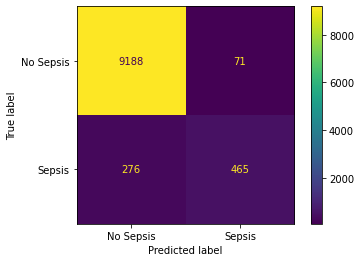

In [108]:
cm = confusion_matrix(Y_test, y_pred, labels=xgboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Sepsis', 'Sepsis'])
disp.plot()
plt.show()

In [109]:
all_data_means_test_with_Y = all_data_means_test.copy()
all_data_means_test_with_Y['Y'] = Y_test

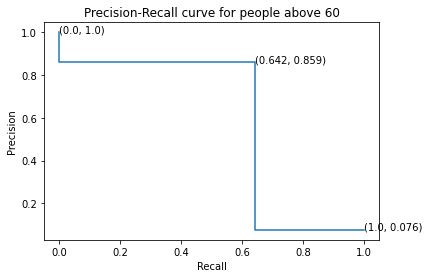

In [110]:
X_test_above_60 = all_data_means_test_with_Y[all_data_means_test_with_Y['Age']>=60]
Y_test_above_60 = X_test_above_60['Y']
X_test_above_60 = X_test_above_60.drop(columns='Y')
Y_pred_above_60 = xgboost.predict(X_test_above_60)

precision_a, recall_a, _ = precision_recall_curve(Y_test_above_60, Y_pred_above_60)
disp = PrecisionRecallDisplay(precision=precision_a, recall=recall_a)
disp.plot()
plt.title('Precision-Recall curve for people above 60')
for r,p in zip(recall_a, precision_a):
    r_ = round(r, 3)
    p_ = round(p, 3)
    plt.text(r, p, str((r_,p_)))
plt.show()

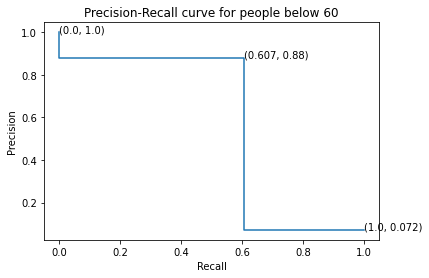

In [111]:
X_test_below_60 = all_data_means_test_with_Y[all_data_means_test_with_Y['Age']<60]
Y_test_below_60 = X_test_below_60['Y']
X_test_below_60 = X_test_below_60.drop(columns='Y')
Y_pred_below_60 = xgboost.predict(X_test_below_60)

precision_b, recall_b, _ = precision_recall_curve(Y_test_below_60, Y_pred_below_60)
disp = PrecisionRecallDisplay(precision=precision_b, recall=recall_b)
disp.plot()
plt.title('Precision-Recall curve for people below 60')
for r,p in zip(recall_b, precision_b):
    r_ = round(r, 3)
    p_ = round(p, 3)
    plt.text(r, p, str((r_,p_)))
plt.show()

In [ ]:
auc_a = auc(recall_a, precision_a)
auc_b = auc(recall_b, precision_b)
print('AUC below 60:', auc_b)
print('AUC above 60:', auc_a)

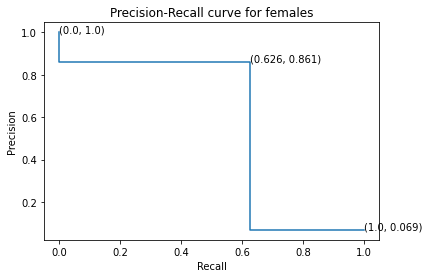

In [114]:
X_test_females = all_data_means_test_with_Y[all_data_means_test_with_Y['Gender']==0]
Y_test_females = X_test_females['Y']
X_test_females = X_test_females.drop(columns='Y')
Y_pred_females = xgboost.predict(X_test_females)

precision_f, recall_f, _ = precision_recall_curve(Y_test_females, Y_pred_females)
disp = PrecisionRecallDisplay(precision=precision_f, recall=recall_f)
disp.plot()
plt.title('Precision-Recall curve for females')
for r,p in zip(recall_f, precision_f):
    r_ = round(r, 3)
    p_ = round(p, 3)
    plt.text(r, p, str((r_,p_)))
plt.show()

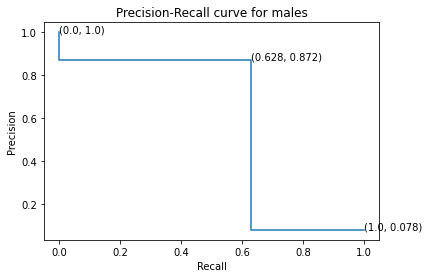

In [115]:
X_test_males = all_data_means_test_with_Y[all_data_means_test_with_Y['Gender']==1]
Y_test_males = X_test_males['Y']
X_test_males = X_test_males.drop(columns='Y')
Y_pred_males = xgboost.predict(X_test_males)

precision_m, recall_m, _ = precision_recall_curve(Y_test_males, Y_pred_males)
disp = PrecisionRecallDisplay(precision=precision_m, recall=recall_m)
disp.plot()
plt.title('Precision-Recall curve for males')
for r,p in zip(recall_m, precision_m):
    r_ = round(r, 3)
    p_ = round(p, 3)
    plt.text(r, p, str((r_,p_)))
plt.show()

In [ ]:
auc_f = auc(recall_f, precision_f)
auc_m = auc(recall_m, precision_m)
print('AUC female:', auc_f)
print('AUC male:', auc_m)

In [117]:
# Fits the explainer
explainer = shap.Explainer(xgboost.predict, all_data_means_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(all_data_means_test)


Permutation explainer:   1%|▏         | 142/10000 [00:38<44:31,  3.69it/s]


Permutation explainer:   2%|▏         | 247/10000 [01:07<45:37,  3.56it/s]


Permutation explainer:   4%|▎         | 352/10000 [01:37<43:58,  3.66it/s]


Permutation explainer:   5%|▍         | 457/10000 [02:07<44:53,  3.54it/s]


Permutation explainer:   6%|▌         | 562/10000 [02:36<46:04,  3.41it/s]


Permutation explainer:   7%|▋         | 667/10000 [03:05<43:35,  3.57it/s]


Permutation explainer:   8%|▊         | 772/10000 [03:35<42:30,  3.62it/s]


Permutation explainer:   9%|▉         | 877/10000 [04:04<41:52,  3.63it/s]


Permutation explainer:  10%|▉         | 982/10000 [04:34<44:54,  3.35it/s]


Permutation explainer:  11%|█         | 1085/10000 [05:02<43:30,  3.41it/s]


Permutation explainer:  12%|█▏        | 1188/10000 [05:32<43:36,  3.37it/s]


Permutation explainer:  13%|█▎        | 1291/10000 [06:00<40:59,  3.54it/s]


Permutation explainer:  14%|█▍        | 1394/10000 [06:30<41:18,  3.47it/s]


Permutation explainer:  15%|█▍        | 1497/10000 [06:59<40:05,  3.53it/s]


Permutation explainer:  16%|█▌        | 1600/10000 [07:28<38:52,  3.60it/s]


Permutation explainer:  17%|█▋        | 1703/10000 [07:57<53:10,  2.60it/s]


Permutation explainer:  18%|█▊        | 1806/10000 [08:26<38:24,  3.56it/s]


Permutation explainer:  19%|█▉        | 1909/10000 [08:55<38:43,  3.48it/s]


Permutation explainer:  20%|██        | 2012/10000 [09:24<36:01,  3.70it/s]


Permutation explainer:  21%|██        | 2115/10000 [09:53<37:38,  3.49it/s]


Permutation explainer:  22%|██▏       | 2218/10000 [10:22<38:51,  3.34it/s]


Permutation explainer:  23%|██▎       | 2321/10000 [10:51<34:27,  3.71it/s]


Permutation explainer:  24%|██▍       | 2424/10000 [11:19<33:22,  3.78it/s]


Permutation explainer:  25%|██▌       | 2527/10000 [11:48<36:19,  3.43it/s]


Permutation explainer:  26%|██▋       | 2630/10000 [12:18<34:55,  3.52it/s]


Permutation explainer:  27%|██▋       | 2733/10000 [12:47<34:14,  3.54it/s]


Permutation explainer:  28%|██▊       | 2836/10000 [13:16<35:41,  3.35it/s]


Permutation explainer:  29%|██▉       | 2939/10000 [13:45<32:14,  3.65it/s]


Permutation explainer:  30%|███       | 3042/10000 [14:14<32:42,  3.55it/s]


Permutation explainer:  31%|███▏      | 3145/10000 [14:44<32:46,  3.49it/s]


Permutation explainer:  32%|███▏      | 3248/10000 [15:12<31:14,  3.60it/s]


Permutation explainer:  34%|███▎      | 3351/10000 [15:42<30:04,  3.69it/s]


Permutation explainer:  35%|███▍      | 3454/10000 [16:11<31:47,  3.43it/s]


Permutation explainer:  36%|███▌      | 3557/10000 [16:40<29:49,  3.60it/s]


Permutation explainer:  37%|███▋      | 3660/10000 [17:10<28:49,  3.67it/s]


Permutation explainer:  38%|███▊      | 3763/10000 [17:39<28:31,  3.64it/s]


Permutation explainer:  39%|███▊      | 3866/10000 [18:08<28:26,  3.60it/s]


Permutation explainer:  40%|███▉      | 3969/10000 [18:38<29:04,  3.46it/s]


Permutation explainer:  41%|████      | 4072/10000 [19:07<29:02,  3.40it/s]


Permutation explainer:  42%|████▏     | 4175/10000 [19:43<44:21,  2.19it/s]


Permutation explainer:  43%|████▎     | 4278/10000 [20:33<43:57,  2.17it/s]


Permutation explainer:  44%|████▍     | 4381/10000 [21:23<46:32,  2.01it/s]


Permutation explainer:  45%|████▍     | 4484/10000 [22:12<43:22,  2.12it/s]


Permutation explainer:  46%|████▌     | 4587/10000 [23:10<50:25,  1.79it/s]


Permutation explainer:  47%|████▋     | 4690/10000 [23:43<24:41,  3.59it/s]


Permutation explainer:  48%|████▊     | 4793/10000 [24:12<25:33,  3.40it/s]


Permutation explainer:  49%|████▉     | 4896/10000 [24:41<24:27,  3.48it/s]


Permutation explainer:  50%|████▉     | 4999/10000 [25:11<23:28,  3.55it/s]


Permutation explainer:  51%|█████     | 5102/10000 [25:40<22:29,  3.63it/s]


Permutation explainer:  52%|█████▏    | 5205/10000 [26:09<21:24,  3.73it/s]


Permutation explainer:  53%|█████▎    | 5308/10000 [26:37<20:54,  3.74it/s]


Permutation explainer:  54%|█████▍    | 5411/10000 [27:06<21:27,  3.56it/s]


Permutation explainer:  55%|█████▌    | 5514/10000 [27:36<20:36,  3.63it/s]


Permutation explainer:  56%|█████▌    | 5617/10000 [28:15<33:46,  2.16it/s]


Permutation explainer:  57%|█████▋    | 5720/10000 [29:04<34:28,  2.07it/s]


Permutation explainer:  58%|█████▊    | 5823/10000 [29:52<33:10,  2.10it/s]


Permutation explainer:  59%|█████▉    | 5926/10000 [30:42<34:55,  1.94it/s]


Permutation explainer:  60%|██████    | 6029/10000 [31:36<33:36,  1.97it/s]


Permutation explainer:  61%|██████▏   | 6132/10000 [32:30<32:29,  1.98it/s]


Permutation explainer:  62%|██████▏   | 6235/10000 [33:23<33:26,  1.88it/s]


Permutation explainer:  63%|██████▎   | 6338/10000 [34:16<29:54,  2.04it/s]


Permutation explainer:  64%|██████▍   | 6441/10000 [35:05<27:33,  2.15it/s]


Permutation explainer:  65%|██████▌   | 6544/10000 [35:53<26:14,  2.19it/s]


Permutation explainer:  66%|██████▋   | 6647/10000 [36:43<26:20,  2.12it/s]


Permutation explainer:  68%|██████▊   | 6750/10000 [37:34<24:35,  2.20it/s]


Permutation explainer:  69%|██████▊   | 6853/10000 [38:28<27:49,  1.88it/s]


Permutation explainer:  70%|██████▉   | 6956/10000 [39:24<27:55,  1.82it/s]


Permutation explainer:  71%|███████   | 7059/10000 [40:19<27:09,  1.80it/s]


Permutation explainer:  72%|███████▏  | 7162/10000 [41:15<25:00,  1.89it/s]


Permutation explainer:  73%|███████▎  | 7265/10000 [42:10<24:15,  1.88it/s]


Permutation explainer:  74%|███████▎  | 7368/10000 [43:05<22:24,  1.96it/s]


Permutation explainer:  75%|███████▍  | 7471/10000 [44:00<22:31,  1.87it/s]


Permutation explainer:  76%|███████▌  | 7574/10000 [44:55<21:37,  1.87it/s]


Permutation explainer:  77%|███████▋  | 7677/10000 [45:50<19:11,  2.02it/s]


Permutation explainer:  78%|███████▊  | 7780/10000 [46:38<17:03,  2.17it/s]


Permutation explainer:  79%|███████▉  | 7883/10000 [47:26<16:24,  2.15it/s]


Permutation explainer:  80%|███████▉  | 7986/10000 [48:15<15:48,  2.12it/s]


Permutation explainer:  81%|████████  | 8089/10000 [49:02<15:35,  2.04it/s]


Permutation explainer:  82%|████████▏ | 8192/10000 [49:50<14:19,  2.10it/s]


Permutation explainer:  83%|████████▎ | 8295/10000 [50:38<10:10,  2.79it/s]


Permutation explainer:  84%|████████▍ | 8398/10000 [51:07<07:24,  3.60it/s]


Permutation explainer:  85%|████████▌ | 8501/10000 [51:36<06:44,  3.70it/s]


Permutation explainer:  86%|████████▌ | 8604/10000 [52:05<06:06,  3.81it/s]


Permutation explainer:  87%|████████▋ | 8707/10000 [52:34<06:13,  3.46it/s]


Permutation explainer:  88%|████████▊ | 8810/10000 [53:04<05:43,  3.47it/s]


Permutation explainer:  89%|████████▉ | 8913/10000 [53:33<05:30,  3.29it/s]


Permutation explainer:  90%|█████████ | 9016/10000 [54:02<04:33,  3.60it/s]


Permutation explainer:  91%|█████████ | 9119/10000 [54:31<04:08,  3.55it/s]


Permutation explainer:  92%|█████████▏| 9222/10000 [55:00<03:50,  3.38it/s]


Permutation explainer:  93%|█████████▎| 9325/10000 [55:30<03:17,  3.42it/s]


Permutation explainer:  94%|█████████▍| 9428/10000 [56:00<02:41,  3.54it/s]


Permutation explainer:  95%|█████████▌| 9531/10000 [56:30<02:18,  3.39it/s]


Permutation explainer:  96%|█████████▋| 9634/10000 [57:00<01:44,  3.49it/s]


Permutation explainer:  97%|█████████▋| 9737/10000 [57:30<01:14,  3.51it/s]


Permutation explainer:  98%|█████████▊| 9840/10000 [57:59<00:45,  3.49it/s]


Permutation explainer:  99%|█████████▉| 9943/10000 [58:29<00:15,  3.62it/s]


Permutation explainer: 100%|██████████| 10000/10000 [58:45<00:00,  3.64it/s]
Permutation explainer: 10001it [58:46,  2.83it/s]                           


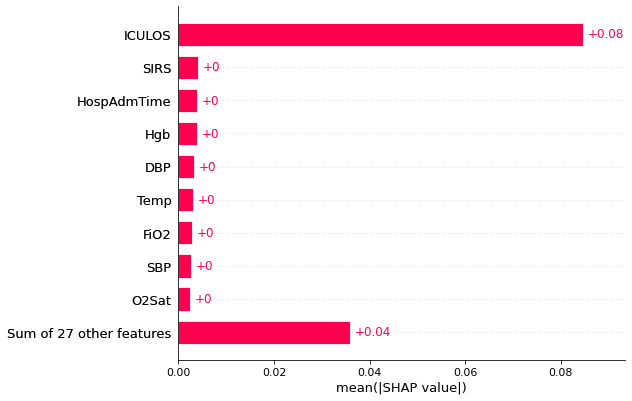

In [118]:
shap.plots.bar(shap_values)

In [119]:
shap_values

.values =
array([[ 1.66666667e-03,  8.33333333e-04, -8.33333333e-04, ...,
         1.66666667e-03, -2.91666667e-02,  8.33333333e-04],
       [ 8.33333333e-04, -3.33333333e-03,  0.00000000e+00, ...,
        -8.33333333e-04, -2.58333333e-02, -1.66666667e-03],
       [ 8.33333333e-04, -1.66666667e-03, -8.33333333e-04, ...,
         1.66666667e-03, -3.75000000e-02, -2.89120579e-19],
       ...,
       [ 1.66666667e-03, -5.00000000e-03,  8.33333333e-04, ...,
        -1.16666667e-02, -2.08333333e-02, -1.66666667e-03],
       [-7.22801448e-19, -4.16666667e-03, -8.33333333e-04, ...,
        -1.08333333e-02,  3.33333333e-03,  7.50000000e-03],
       [ 8.33333333e-04, -8.33333333e-04,  0.00000000e+00, ...,
        -1.66666667e-03, -3.16666667e-02,  8.33333333e-04]])

.base_values =
array([0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02])

.data =
array([[ 6.24642857e+01,  9.84285714e+01,  3.66000000e+01, ...,
        -3.00000000e-02,  1.50000000e+01,  1.33333333e-01],
       [ 7.04000000e+01,  9.4200000